In [13]:
from dataset import DetectionDataset
from utils import plot_images
from default_boxes import *
from utils import xywh2xyxy, draw_rectangles, images_with_rectangles,xyxy2xywh
import matplotlib.pyplot as plt
from iou import calculate_iou

## 데이터 다운로드 

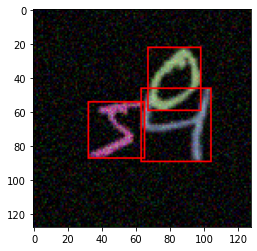

In [14]:
# get sample image and object coordinates 
trainset = DetectionDataset(data_type='train')
sample_image, sample_labels = trainset[0]
sample_labels = sample_labels.iloc[:, 1:5].values
sample_labels = xywh2xyxy(sample_labels)

# visualization 
rected_image = draw_rectangles(sample_image*255, sample_labels)
plt.imshow(rected_image)
plt.show()

## Feature map 의 Cell 을 original image 좌표로 맵핑

In [15]:
fmap = tf.constant(shape=(2, 8, 8, 2), value=1)
h, w = fmap.get_shape()[1:3]
n_layer = 11
paddings = ['SAME'] * n_layer
strides = [1, 1, 1, 1, 2, 1, 2, 1, 2, 1, 2]
kernel_sizes = [3] * n_layer
center_xy = original_rectangle_coords((h, w), kernel_sizes, strides, paddings)[:, :2]

## Generate Default Boxes 
 - 지정된 크기와 비율에 맞는 default boxes 을 생성

In [16]:
# get w, h
scales = [30]
ratios = [(1, 1),
          (1.5, 0.5),
          (1.2, 0.8),
          (0.8, 1.2),
          (1.4, 1.4)]
sizes = generate_default_boxes(scales, ratios)

## 생성된 Default Boxes 을 orignal image 좌표에 매칭(Tiling)

In [17]:
# Get default boxes over feature map
default_boxes = tiling_default_boxes(center_xy, sizes)
default_boxes = xywh2xyxy(default_boxes)

# opencv 는 minus 좌표계를 지원하지 않아서 minus 좌표계는 0으로 변환함
sample_clipped_boxes = np.where(default_boxes >0, default_boxes, 0)

# 좌표 하나에 그려질 모든 anchor을 그린다.
n_samples = h * w
backgrounds = [rected_image]*n_samples
rected_imgs = images_with_rectangles(backgrounds, sample_clipped_boxes)

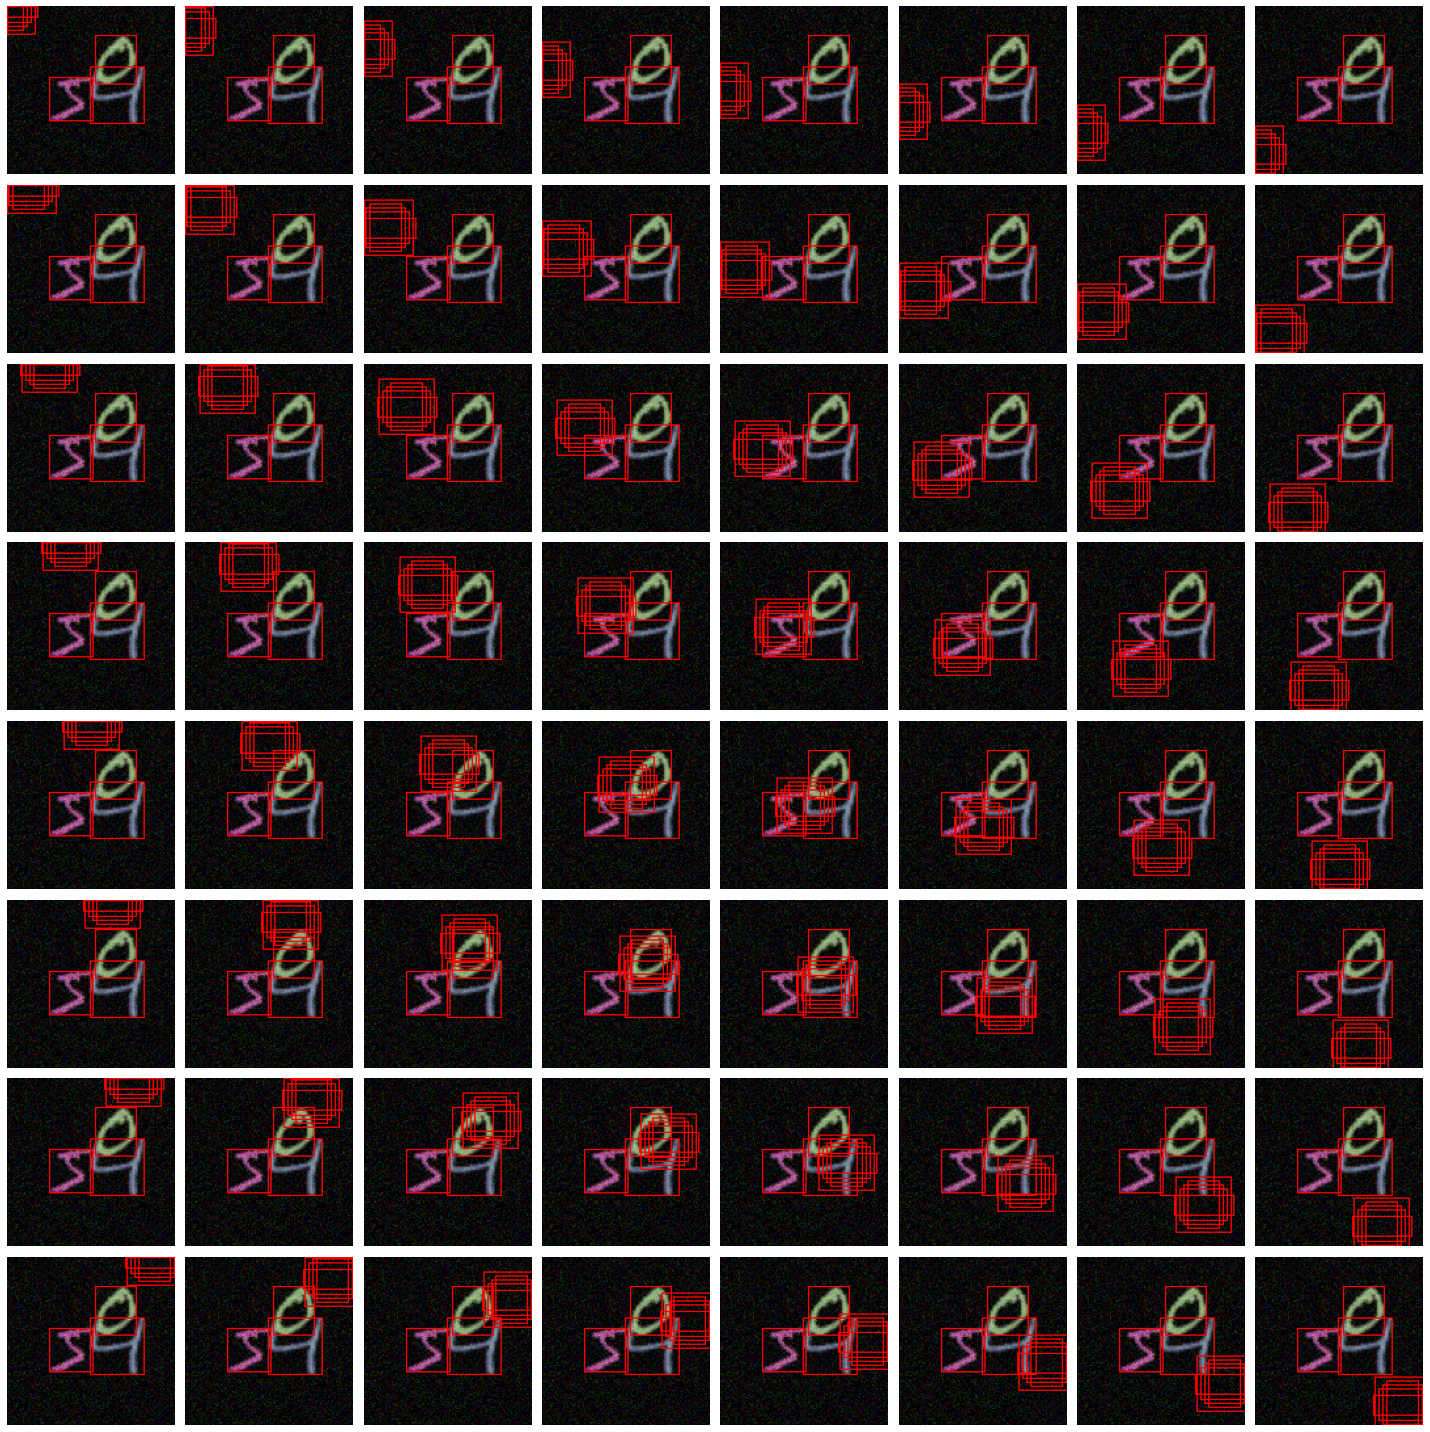

In [18]:
# tiling 된 이미지를 시각화 함 
plot_images(rected_imgs)

### Ground truth 와 default boxes 와의  IOU 을 계산

In [19]:
# flatten default boxes (N, 5, 4) -> (N*5, 4)
default_boxes = default_boxes.reshape(-1, 4)

In [20]:
# ground truths 와 default_boxes iou 을 계산
ious = calculate_iou(xyxy2xywh(default_boxes), xyxy2xywh(sample_labels))

# iou 가 0.5 이상 되는 default boxes 의 index 을 추출 
bool_mask = np.any((ious) > 0.5, axis=-1)
positive_index = np.where(bool_mask)

pos_default_boxes = default_boxes[positive_index]

In [21]:
over_iou = draw_rectangles(rected_image, np.array(pos_default_boxes))

### Visualization IOU over 50

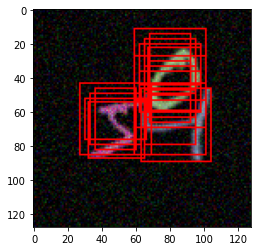

In [22]:
plt.imshow(over_iou)